In [144]:
library(rJava)
library (CropPhenology)
library(data.table)
library(rTIMESAT)
library(magrittr)
library(ggplot2)

In [154]:
path <- "C:/Users/User/Documents/NOA_e-shape/Korea-Data_Thanassis/wetransfer-09e80a"
setwd(path)

TIMESAT package is used for extracting seasonality parameters. TIMESAT smooths each of the time-series in a defined area and extracts seasonality data such as start and end of the season or the length of the season.

TIMESAT need as input the number of seasons and their approximate timing. It uses three smothing methods:
i) Savitzky-Golay
ii) Least Squares - Assymetric Gaussians
iii) Double Logistic functions

In [155]:
TSF_main <- function(d, nptperyear = 25, cache = F){
  
  ## 1. Prepare inputs
  sitename <- "maria1"
  nyear <- floor(nrow(d)/nptperyear)
  npt   <- nyear * nptperyear
  
  # pls make sure it's complete year in input
  file_y   <- sprintf("TSM_%s_y.txt", sitename)
  file_w   <- sprintf("TSM_%s_w.txt", sitename)
  file_set <- sprintf("TSM_%s.set", sitename)
  
  write_input(d$NDVI  , file_y, nptperyear)
  write_input(rep(1,nrow(d)) %>% as.numeric(), file_w, nptperyear)
  
  ## 2. Update options
  options <- list(
    job_name            = "",
    file_y              = file_y,             # Data file list/name
    file_w              = file_w,             # Mask file list/name
    nyear_and_nptperear = c(nyear, nptperyear),      # No. years and no. points per year
    ylu                 = c(-9999, 9999),     # Valid data range (lower upper)
    
  ## In TIMESAT cloud classifications and other ancillary data may be used to assign weights to the values in the timeseries series.
  ## There are no general rules for converting ancillary data to weights associated with the values in the timeseries.    
    has_QC              = 0,              # 1 = use quality data, 0 = do not use quality data. 
    qc_1                = c(0, 0, 1),     # Quality range 1 and weight
    qc_2                = c(1, 1, 0.5),   # Quality range 2 and weight
    qc_3                = c(2, 3, 0.2),   # Quality range 3 and weight
      
  ## Amplitude cuttoff: Minimum Vegetation Index values' range (Works as a threshold)  
    A                   = 0.1,            # Amplitude cutoff value
    output_type         = c(1, 1, 0),     # Output files (1/0 1/0 1/0), 1: seasonality data; 2: smoothed time-series; 3: original time-series
    
    spike_meth          = 0,              # (0/1/2/3): (no spike detection/method based on median filtering/weights from STL-decomposition/weights from STL-decomposition).
    spike_sd            = 1,              # Numeric, data values that differ from the median value by more than the spike_sd multiplied with the standard deviation of y and that are different from the left and right neighbors are removed (assigned weight 0).      
    seasonpar           = 1.0,            # Seasonality parameter (0-1)
  
  ## No. of envelope iter: How many times fitted function will be applied. Setting 2 or 3 the fit will decrease the weights of the low data 
  ## values, one to two times respectivelly.    
    iters               = 1,              # No. of envelope iterations (3/2/1)
    adapt               = 1,              # Adaptation strength. The adaptation strength is a number between 1 and 10 indicating the strength of the upper envelope adaptation.
    FUN                 = 1,              # Fitting method (1/2/3): (Savitzky-Golay / Asymmetric Gaussians / Double logistic Functions)
    half_win            = 4,              # half Window size for Sav-Gol. In case of Asym.Gaus. or Double.Logist will not be taken into account.
    meth_pheno          = 1,              # (1: seasonal amplitude, 2: absolute value, 3: relative amplitude, 4: STL trend)
    trs                 = c(0.5, 0.5)     # Season start / end values
  )
  
  options$job_name <- sitename
  
  opt <- update_setting(options)
  write_setting(opt, file_set)
  
  TSF_process(file_set) # call TSF_process.exe
  
  file_tts <- sprintf("%s_fit.tts", opt$job_name)
  file_tpa <- sprintf("%s_TS.tpa", opt$job_name)
  
  # note: only suit for ascii
  tidy_tts <- function(d_tts){
    sites <- d_tts$row %>% paste0("v", .)
    npt   <- ncol(d_tts) - 2
    d <- d_tts %>% {.[, 3:ncol(.)]} %>% as.matrix() %>% t() %>% data.frame() %>%
      set_colnames(sites) %>% cbind(t = 1:npt, .)
    d
  }
  
  d_tts <- read_tts(file_tts) %>% tidy_tts()
  d_tpa <- read_tpa(file_tpa)
  
  if (!cache){
    status1 <- file.remove(c(file_tts, file_tpa, file_y, file_w, file_set))
    status2 <- dir(".", "*.ndx", full.names = T) %>% file.remove()
  }
  list(fit = d_tts, pheno = d_tpa)
}

Phenological Parameters in TimeSat:
1. Time for the start of the season; time for which the left has increased to a user defined level (often 20%) measured from the left min.
2. Time for the end; time for which the right edge has decreased to a user defined from the right minimum.
3. Length of the period; time from start to end
4. Base level; given as the average of the left and right min values
5. Time for the mid of the season; computed as the mean value of the times for which respectively, the left edge has increased to 80% level and the right edge has decreased to the 80% level.
6. Largest data value for the fitted function during season
7. Seasonal amplitude; difference between the maximal value and the base level
8. Rate of increase at the beginning of the season; calculated as the ration between the values evaluated at the season start and at the left 80% level divided by the correct time difference
9. Rate of decrease at the end of the season; at the season end at the right 80% level divided by corr. time
10. Large Seasonal integral.
11. Small Seasonal integral.

In [1]:
pathtofile <- "C:/Users/User/Documents/NOA_e-shape/Korea-Data_Thanassis/wetransfer-09e80a/interpolated_df_nn_fulltime.csv" 
rice <- as.data.frame(fread(pathtofile, header=F))
colnames(rice) <- rice[1,]
rice <- rice[-1,]
rice <- rbind(rice,rice)
rice <- rice[-1]

ERROR: Error in fread(pathtofile, header = F): could not find function "fread"


TIMESAT needs as input timeseries per year and large amplitude, many decades. If dataset has timeseries only for one year, then dubplicate or triplecate it to work. 

In [157]:
rice[1:10,1:10]

,2019-03-10,2019-03-20,2019-03-30,2019-04-10,2019-04-20,2019-04-30,2019-05-10,2019-05-20,2019-05-30,2019-06-10
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,221.4937,158.4921,139.9091,155.7404,189.4430,213.8895,185.0671,211.3226,371.2179,517.6092
3,212.82404,109.53846,88.59296,124.17668,176.65710,197.20308,113.33114,55.83492,147.71278,302.41820
4,238.39798,136.69881,118.08474,155.66540,208.14684,221.17180,111.27477,45.71994,168.12143,320.75305
5,201.5028,116.9077,107.5394,149.6917,204.4011,224.7080,138.3899,83.5635,184.4179,330.6723
6,180.7478,171.6532,173.4408,181.2109,187.4011,178.5188,130.8964,108.1516,170.6409,292.4629
7,189.6896,119.4432,108.3780,139.2420,183.4065,218.3921,217.4083,180.7077,143.0232,221.6167
8,182.7741,156.0872,152.5695,164.8150,180.9197,186.9277,161.8629,143.2156,177.3407,286.8962
9,236.78650,210.72689,191.10183,172.98125,156.05531,127.90696,69.41510,38.07293,97.67516,264.65884
10,231.91905,205.93345,193.96003,188.19285,181.69823,154.27718,72.52431,29.35146,110.81448,268.95438


In [158]:
dates <- rice$daily
obj <- colnames(rice[2:ncol(rice)])
ricen <- rice[2:ncol(rice)]

In [161]:
ricen[1:10,1:10]

NDVI,NDVI.1,NDVI.2,NDVI.3,NDVI.4,NDVI.5,NDVI.6,NDVI.7,NDVI.8,NDVI.9
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
158.4921,139.9091,155.7404,189.4430,213.8895,185.0671,211.3226,371.2179,517.6092,596.9302
109.53846,88.59296,124.17668,176.65710,197.20308,113.33114,55.83492,147.71278,302.41820,445.93172
136.69881,118.08474,155.66540,208.14684,221.17180,111.27477,45.71994,168.12143,320.75305,436.78388
116.9077,107.5394,149.6917,204.4011,224.7080,138.3899,83.5635,184.4179,330.6723,456.1974
171.6532,173.4408,181.2109,187.4011,178.5188,130.8964,108.1516,170.6409,292.4629,424.9826
119.4432,108.3780,139.2420,183.4065,218.3921,217.4083,180.7077,143.0232,221.6167,377.4910
156.0872,152.5695,164.8150,180.9197,186.9277,161.8629,143.2156,177.3407,286.8962,422.7822
210.72689,191.10183,172.98125,156.05531,127.90696,69.41510,38.07293,97.67516,264.65884,460.69321
205.93345,193.96003,188.19285,181.69823,154.27718,72.52431,29.35146,110.81448,268.95438,432.15820


In [160]:
colnames(ricen) <- rep("NDVI",ncol(ricen))
row.names(ricen) <- 1:nrow(rice)

In [153]:
#TimeSat
l <- list()
for (i in 1: ncol(ricen)){
  l[i] <- list(TSF_main(ricen[i]))
}

ERROR: Error in names(x) <- value: 'names' attribute [16] must be the same length as the vector [0]


In [90]:
phenolist <- list()
for (i in 1:length(l)){
  phenolist[i] <- list(l[[i]]$pheno)
}

In [91]:
phenolist <- data.frame(matrix(unlist(phenolist), nrow=length(phenolist), byrow=T))
colnames(phenolist) <- c("row", "col", "season", "time_start", "time_end", "time_peak", "len", "val_start", "val_end","val_peak", "val_base", "ampl", "der_l", "der_r", "integ_large", "integ_small")
row.names(phenolist) <- obj
phenolist[1:5,1:ncol(phenolist)]

,row,col,season,time_start,time_end,time_peak,len,val_start,val_end,val_peak,val_base,ampl,der_l,der_r,integ_large,integ_small
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,1,1,1,10.30691,22.06402,16.54910,11.757109,500.1835,500.1835,842.1780,158.1891,683.9888,87.20371,110.4130,9541.217,7326.570
110,1,1,1,11.41991,22.48041,17.01886,11.060491,495.5674,495.5674,871.0121,120.1226,750.8895,126.73415,116.2375,9192.518,7630.924
111,1,1,1,11.63543,22.37831,16.95647,10.742872,511.7146,511.7146,890.6611,132.7682,757.8929,128.01216,107.8696,9222.448,7496.462
112,1,1,1,11.45145,21.87033,16.60111,10.418884,508.3320,501.5473,869.3218,140.5575,728.7643,122.62640,107.0461,8506.385,6819.695
113,1,1,1,11.68167,21.46642,16.57726,9.784752,517.0316,517.0316,898.8629,135.2003,763.6626,130.70656,123.2175,8543.068,6920.665


In [92]:
plotlistv <- list()
for (i in 1:length(l)){
  plotlistv[i] <- list(l[[i]]$fit$v1)
}
plotlistv <- data.frame(matrix(unlist(plotlistv), nrow=length(plotlistv), byrow=T))
plotlistv <- as.data.frame(t(plotlistv))
plotlistd <- as.data.frame(as.Date(dates))
plotl <- cbind(plotlistd,plotlistv)
colnames(plotl)[1] <-"date"
colnames(plotl)[2:ncol(plotl)] <- obj
plotl[1:10,1:10]

,date,109,110,111,112,113,114,115,116,117
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,2019-03-10,183.3217,156.9489,179.2540,148.2959,168.2081,142.1075,166.0582,199.75111,202.45958
X2,2019-03-20,166.8784,128.9249,154.4576,133.7728,176.0298,136.1862,162.3961,196.57433,191.44746
X3,2019-03-30,161.3805,129.8558,162.5190,147.3422,181.3359,138.2491,163.4542,194.64597,198.54153
X4,2019-04-10,165.5746,141.5263,173.5704,165.4471,180.3862,150.8810,166.9984,180.49870,194.75922
X5,2019-04-20,158.1891,131.5856,154.0773,158.3149,168.3521,173.3941,166.9223,138.85234,154.55865
X6,2019-04-30,173.6629,125.4199,140.9192,153.9119,147.5174,187.7252,159.6030,95.29352,110.86060
X7,2019-05-10,215.1492,120.1226,132.7682,150.9187,135.2003,181.6364,154.0752,66.63705,81.62102
X8,2019-05-20,282.1911,133.6237,143.7051,164.8191,147.1236,175.6640,166.7095,77.92503,88.41434
X9,2019-05-30,369.5294,184.8503,188.2021,212.0232,196.2190,198.1065,213.2633,121.01205,146.91707


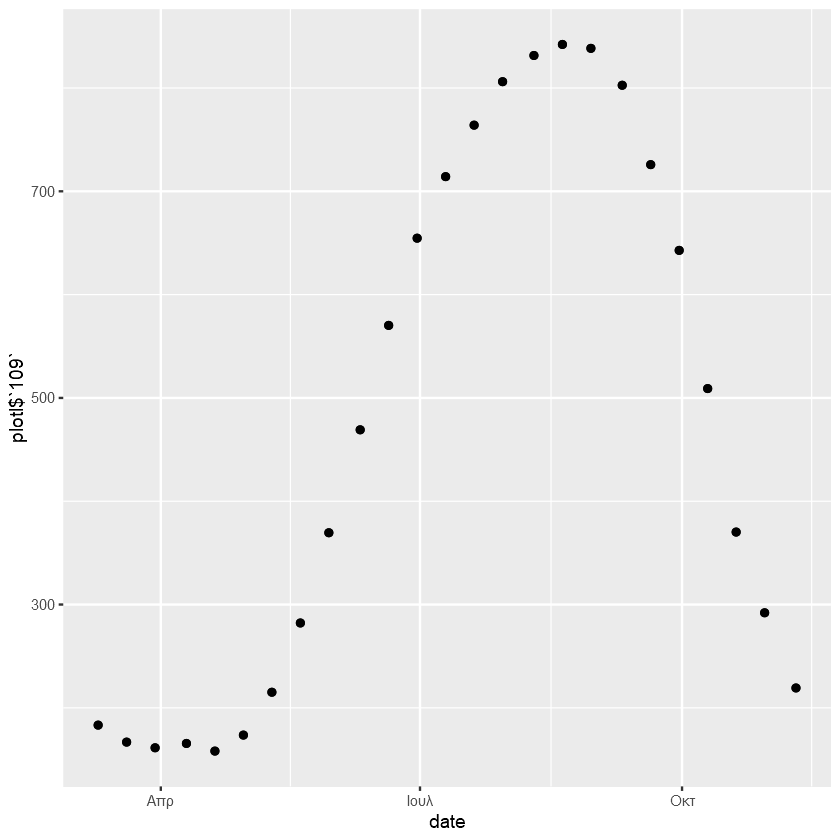

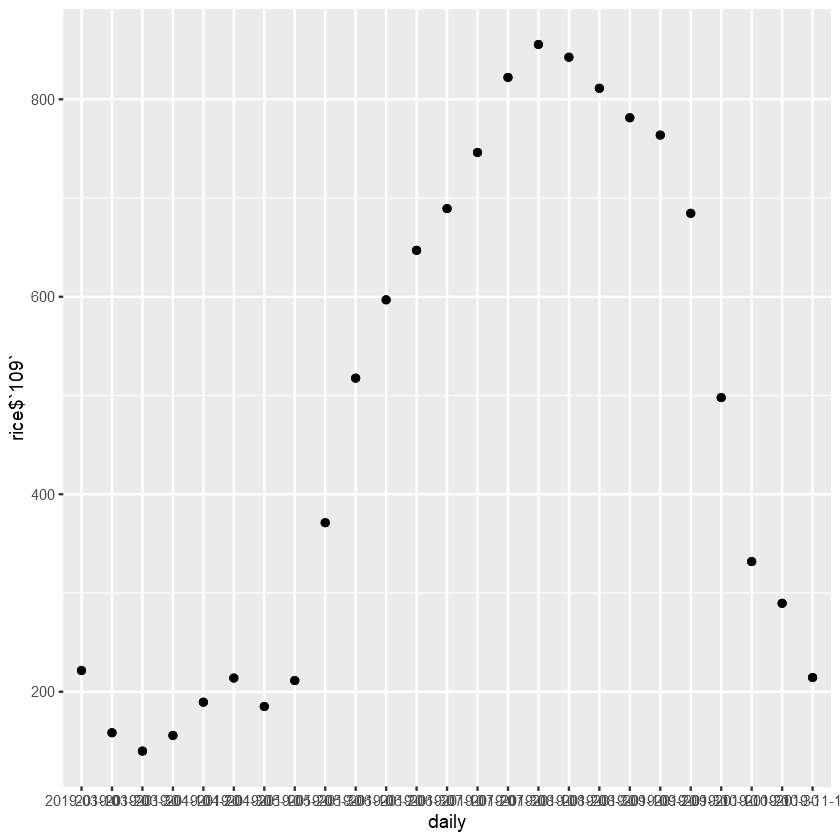

In [46]:
ggplot(data = plotl, mapping = aes(x = date, y = plotl$`109`)) +
  geom_point()
ggplot(data = rice, mapping = aes(x = daily, y= rice$`109`)) +
  geom_point()

In [176]:
write.csv(phenolist, "C:/Users/User/Documents/NOA_e-shape/Korea-Data_Thanassis/wetransfer-09e80a/phenolist.csv",row.names = T)
write.csv(plotl, "C:/Users/User/Documents/NOA_e-shape/Korea-Data_Thanassis/wetransfer-09e80a/plotl.csv",row.names = T)

CropPhenology package computes 15 phenological metrics based on satellite-based NDVI measurements over the season which can be easily visualised and used for successive spatio-temporal analysis.

In [137]:
pathtofile <- "C:/Users/User/Documents/NOA_e-shape/Korea-Data_Thanassis/wetransfer-09e80a/interpolated_df_nn_fulltime2.csv" 
ricepn <- as.data.frame(fread(pathtofile, header=T))
ricepn <- ricepn[-c(1,2)]
ricepn <- as.data.frame(t(ricepn))

In [108]:
ricepn[1:10,1:10]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,221.4937,158.49211,139.90911,155.7404,189.4430,213.8895,185.06713,211.32260,371.21790,517.6092
110,212.8240,109.53846,88.59296,124.1767,176.6571,197.2031,113.33114,55.83492,147.71278,302.4182
111,238.3980,136.69881,118.08474,155.6654,208.1468,221.1718,111.27477,45.71994,168.12143,320.7530
112,201.5028,116.90770,107.53939,149.6917,204.4011,224.7080,138.38987,83.56350,184.41790,330.6723
113,180.7478,171.65324,173.44076,181.2109,187.4011,178.5188,130.89638,108.15160,170.64090,292.4629
114,189.6896,119.44316,108.37799,139.2420,183.4065,218.3921,217.40827,180.70765,143.02320,221.6167
115,182.7741,156.08719,152.56949,164.8150,180.9197,186.9277,161.86288,143.21560,177.34070,286.8962
116,236.7865,210.72689,191.10183,172.9813,156.0553,127.9070,69.41510,38.07293,97.67516,264.6588
117,231.9190,205.93345,193.96003,188.1928,181.6982,154.2772,72.52431,29.35146,110.81448,268.9544


In [138]:
#CropPhenology
l = list()
for (i in 1:nrow(ricepn)){
    l[i] <- list(SinglePhenology(as.numeric(ricepn[i,]),Percentage=20))
}

Smoothing in most cases eliminates spatial and temporal variability that may be an important information source to understand enviromental conditions that affect crop development. An obvious consequence of smoothing is the reduction of NDVI peaks, hence potentially removing crop-relevant information and affecting the calculation of the metrics, particullary in the identification of the start, maximum and end of growth.

In [139]:
rnam <- c('OnsetV', 'OnsetT','MAxV', 'MaxT', 'OffsetV', 'OffsetT','LengthGS', 'BeforeMaxT', 'AfterMaxT', 'GreenUpSlope', 'BrownDownSlope',  'TINDVI', 'TINDVIBeforeMax', 'TINDVIAfeterMax', 'Assymetry')
cnam <- as.numeric(rownames(rice))
crph <- as.data.frame(l, row.names = rnam, col.names=cnam)
crph <- t(as.data.frame(crph))
row.names(crph) <- obj
crph <- as.data.frame(crph)
crph[1:10,1:ncol(crph)]

,OnsetV,OnsetT,MAxV,MaxT,OffsetV,OffsetT,LengthGS,BeforeMaxT,AfterMaxT,GreenUpSlope,BrownDownSlope,TINDVI,TINDVIBeforeMax,TINDVIAfeterMax,Assymetry
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,167.77013,36,855.7260,155,214.4254,246,210,119,91,5.781142,7.047259,58492.66,55907.66,114376.99,2584.996
110,63.40426,74,883.9883,155,205.4246,246,172,81,91,10.130667,7.456743,44158.56,59340.70,103428.25,-15182.133
111,50.59565,73,904.2549,154,218.9646,246,173,81,92,10.539003,7.448807,43987.32,60501.03,104404.17,-16513.711
112,93.03092,74,883.0690,154,180.2379,246,172,80,92,9.875476,7.639468,44491.10,55642.50,100089.99,-11151.406
113,123.88783,76,918.8240,153,202.6775,246,170,77,93,10.323847,7.700500,43204.46,55314.56,98479.63,-12110.102
114,127.88068,29,927.0844,153,195.3630,241,212,124,88,6.445191,8.315016,50461.16,55054.51,105481.92,-4593.347
115,170.93003,81,881.1470,154,207.1829,246,165,73,92,9.729000,7.325697,41551.86,53699.65,95233.38,-12147.787
116,41.85173,74,916.6509,151,188.1520,246,172,77,95,11.361029,7.668410,42666.17,59301.35,101894.37,-16635.177
117,32.02429,73,933.4703,154,194.9326,246,173,81,92,11.128963,8.027583,44039.49,62300.80,106258.83,-18261.307


In [51]:
write.csv(crph, "C:/Users/User/Documents/NOA_e-shape/Korea-Data_Thanassis/wetransfer-09e80a/croppheno.csv",row.names = T)

In [93]:
#Extract DOYs from TIMESAT output
space <- abs(as.numeric(format(as.Date(rice$daily[1],format="%Y-%m-%d"), format = "%d"))-as.numeric(format(as.Date(rice$daily[2],format="%Y-%m-%d"), format = "%d")))
first_doy <- as.numeric(strftime(rice$daily[1], format = "%j"))
phenolist$time_start <- round(phenolist$time_start * space + first_doy,0)
phenolist$time_end <- round(phenolist$time_end * space + first_doy,0)
phenolist$time_peak <- round(phenolist$time_peak * space + first_doy,0)
phenolist$len <- phenolist$time_end - phenolist$time_start

In [103]:
ds <- format(strptime(phenolist$time_start, format="%j"), format="%m-%d")
de <- format(strptime(phenolist$time_end, format="%j"), format="%m-%d")
d <- cbind(ds,de)
colnames(d) <- c('day_start','day_end')
phenolistn <- cbind(d,phenolist)
phenolistn <- phenolistn[-c(3:6)]

In [104]:
phenolistn[1:10,1:ncol(phenolistn)]

,day_start,day_end,time_end,time_peak,len,val_start,val_end,val_peak,val_base,ampl,der_l,der_r,integ_large,integ_small
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,06-21,10-17,290,234,118,500.1835,500.1835,842.1780,158.18912,683.9888,87.20371,110.41296,9541.217,7326.570
110,07-02,10-21,294,239,111,495.5674,495.5674,871.0121,120.12262,750.8895,126.73415,116.23748,9192.518,7630.924
111,07-04,10-20,293,239,108,511.7146,511.7146,890.6611,132.76816,757.8929,128.01216,107.86961,9222.448,7496.462
112,07-03,10-15,288,235,104,508.3320,501.5473,869.3218,140.55751,728.7643,122.62640,107.04610,8506.385,6819.695
113,07-05,10-11,284,235,98,517.0316,517.0316,898.8629,135.20030,763.6626,130.70656,123.21746,8543.068,6920.665
114,07-07,10-12,285,236,97,515.9840,515.9840,895.7818,136.18622,759.5956,136.83629,121.18666,8519.909,6885.674
115,07-04,10-13,286,235,101,500.0210,500.0210,845.9667,154.07523,691.8915,116.03899,105.77312,8215.723,6366.820
116,06-29,10-17,290,232,110,480.5396,480.5396,894.4420,66.63705,827.8050,165.72737,99.19761,9204.847,8338.564
117,07-02,10-23,296,239,113,495.0048,495.0048,908.3886,81.62102,826.7676,145.48515,112.61842,9536.738,8475.665


In [140]:
#Extract DOYs from CropPhenology output
crph$OnsetT	 <- round(crph$OnsetT + first_doy,0)
crph$OffsetT <- round(crph$OffsetT + first_doy,0)
crph$MaxT <- round(crph$MaxT + first_doy,0)
crph$LengthGS <- crph$OffsetT - crph$OnsetT

In [141]:
ds <- format(strptime(crph$OnsetT, format="%j"), format="%m-%d")
de <- format(strptime(crph$OffsetT, format="%j"), format="%m-%d")
d <- cbind(ds,de)
colnames(d) <- c('day_start','day_end')
crph <- cbind(d,crph)

In [142]:
crph[1:10,1:ncol(crph)]

,day_start,day_end,OnsetV,OnsetT,MAxV,MaxT,OffsetV,OffsetT,LengthGS,BeforeMaxT,AfterMaxT,GreenUpSlope,BrownDownSlope,TINDVI,TINDVIBeforeMax,TINDVIAfeterMax,Assymetry
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,04-15,11-11,167.77013,105,855.7260,224,214.4254,315,210,119,91,5.781142,7.047259,58492.66,55907.66,114376.99,2584.996
110,05-23,11-11,63.40426,143,883.9883,224,205.4246,315,172,81,91,10.130667,7.456743,44158.56,59340.70,103428.25,-15182.133
111,05-22,11-11,50.59565,142,904.2549,223,218.9646,315,173,81,92,10.539003,7.448807,43987.32,60501.03,104404.17,-16513.711
112,05-23,11-11,93.03092,143,883.0690,223,180.2379,315,172,80,92,9.875476,7.639468,44491.10,55642.50,100089.99,-11151.406
113,05-25,11-11,123.88783,145,918.8240,222,202.6775,315,170,77,93,10.323847,7.700500,43204.46,55314.56,98479.63,-12110.102
114,04-08,11-06,127.88068,98,927.0844,222,195.3630,310,212,124,88,6.445191,8.315016,50461.16,55054.51,105481.92,-4593.347
115,05-30,11-11,170.93003,150,881.1470,223,207.1829,315,165,73,92,9.729000,7.325697,41551.86,53699.65,95233.38,-12147.787
116,05-23,11-11,41.85173,143,916.6509,220,188.1520,315,172,77,95,11.361029,7.668410,42666.17,59301.35,101894.37,-16635.177
117,05-22,11-11,32.02429,142,933.4703,223,194.9326,315,173,81,92,11.128963,8.027583,44039.49,62300.80,106258.83,-18261.307
